In [1]:
import pandas as pd
import os
import csv
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import cross_val_score
from sklearn import metrics

Pre-processing:

https://www.kaggle.com/datasets/vijeetnigam26/expedia-hotel

In [2]:
f = open(os.getcwd() + "/train.csv", "r")
df = pd.read_csv(f)

In [3]:
# We will be stratifying on our target variable - booking_bool:
df['booking_bool'].value_counts()

0    9640937
1     276593
Name: booking_bool, dtype: int64

In [4]:
booked_df = df[df["booking_bool"] == 1].sample(n=200000, random_state = 42) 

In [5]:
booked_df["booking_bool"].value_counts()

1    200000
Name: booking_bool, dtype: int64

In [6]:
not_booked_sample = df[df["booking_bool"] == 0].sample(n=len(booked_df), random_state = 42) 

In [7]:
not_booked_sample["booking_bool"].value_counts()

0    200000
Name: booking_bool, dtype: int64

In [8]:
stratified = pd.concat([booked_df, not_booked_sample])

In [9]:
stratified["booking_bool"].value_counts()

0    200000
1    200000
Name: booking_bool, dtype: int64

In [10]:
# Separate the features and target variable
X = stratified.drop('booking_bool', axis=1)
y = stratified['booking_bool']

Model Building - Logistic Regression:

In [11]:
# Split the data into training and test sets
X1, X2, y1, y2 = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
train = X1.copy()
train["booking_bool"] = y1

In [13]:
test = X2.copy()
test["booking_bool"] = y2

In [14]:
# train/test split complete
test.head()

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool
3459385,232319,2012-11-21 21:08:43,15,55,NaN,NaN,55,104616,4,3.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,193.02,1
9720664,652462,2012-11-12 18:12:58,5,219,NaN,NaN,219,24500,2,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,88.71,1
2027206,136044,2013-02-25 06:05:49,5,219,NaN,NaN,219,75939,2,3.5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,1,60.15,1
8180884,549561,2013-06-18 21:35:48,15,55,NaN,NaN,219,1497,4,4.0,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,1,208.91,1
3511765,235778,2013-04-16 19:53:46,5,219,NaN,NaN,219,36791,3,4.0,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0


In [15]:
train.head()

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool
8817994,592099,2013-06-09 21:39:15,18,129,NaN,NaN,129,60932,4,4.0,...,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0,NaN,0
7813334,524841,2013-01-27 09:01:42,5,219,NaN,NaN,100,42181,4,4.5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
633535,42333,2013-05-17 10:12:28,14,100,NaN,NaN,100,104112,4,4.5,...,NaN,NaN,NaN,NaN,1.0,0.0,113.0,1,1764.72,1
1357246,90885,2013-04-01 06:58:15,5,219,NaN,NaN,219,69709,2,4.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,179.66,1
4864674,326481,2013-03-26 19:45:34,15,55,NaN,NaN,215,118269,4,3.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0


Creating a new column with binary classification as to whether a location is considered "good":

In [16]:
train_location_median = train["prop_location_score1"].median()
test_location_median = test["prop_location_score1"].median()

In [17]:
def aboveOrBelowTrain(row):
    if row["prop_location_score1"] >= train_location_median:
        return 1
    else:
        return 0

In [18]:
def aboveOrBelowTest(row):
    if row["prop_location_score1"] >= test_location_median:
        return 1
    else:
        return 0

In [19]:
train["isGoodLocation"] = train.apply(aboveOrBelowTrain, axis=1)

In [20]:
test["isGoodLocation"] = test.apply(aboveOrBelowTest, axis=1)

In [21]:
train['booking_bool'].value_counts()

0    160051
1    159949
Name: booking_bool, dtype: int64

Target Variable:
    booking_bool
        - did the customer book this instance or no
        
Explanatory Variables:
    isGoodLocation:
        - 0 or 1 if the location is good.
        
    srch_booking_window:
        - Number of days in the future the hotel stay started from the search date
        
    random_bool:
        - +1 when the displayed sort was random, 0 when the normal sort order was displayed
    
    promotion_flag:
        - +1 if the hotel had a sale price promotion specifically displayed
        
    srch_saturday_night_bool
             - +1 if the stay includes a Saturday night, starts from Thursday with a length of stay is less than or equal to 4 nights (i.e. weekend); otherwise 0
        

In [22]:
predictors = ["srch_saturday_night_bool", "promotion_flag", "random_bool", "srch_booking_window", "isGoodLocation"]




Crossvalidation:
* cv = number of folds
* Cs = list of floats or int with the inverse of regularization strength. smaller values specify stronger regularization
* scoring =  A string or a scorer (see sklearn.metrics). The default scoring option used is ‘accuracy’.

In [23]:
print("n_samples: {0} is greater than n_features {1}".format(train.shape[0], train.shape[1]))

print("Because n_samples >> n_features, we will choose - for now - the newton-cholesky solver:")

n_samples: 320000 is greater than n_features 55
Because n_samples >> n_features, we will choose - for now - the newton-cholesky solver:


In [24]:
X_train = train[predictors]
y_train = train["booking_bool"]
X_test = test[predictors]
y_test = test["booking_bool"]

In [25]:
X_train

,srch_saturday_night_bool,promotion_flag,random_bool,srch_booking_window,isGoodLocation
8817994,0,0,0,1,1
7813334,1,0,0,20,1
633535,1,1,0,64,1
1357246,1,0,0,46,1
4864674,0,1,0,7,1
...,...,...,...,...,...
9742649,0,0,1,2,1
6272216,0,0,0,70,0
3332075,1,0,0,3,0
2404582,0,1,0,53,1


In [26]:
from sklearn.linear_model import LogisticRegressionCV

# inverse regularization strength:
listC = list(np.power(10.0, np.arange(-4, 4)))
model_cv = LogisticRegressionCV(cv=10,Cs=listC, solver="newton-cg")
clf = model_cv.fit(X_train, y_train)

/Users/harrisonbarth/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/harrisonbarth/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/Users/harrisonbarth/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/harrisonbarth/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/Users/harrisonbarth/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge'

In [27]:
# accuracy for each fold
clf.scores_[1]

array([[0.61709375, 0.62015625, 0.6198125 , 0.61978125, 0.61975   ,
        0.61975   , 0.61975   , 0.61975   ],
       [0.61146875, 0.61725   , 0.61809375, 0.618375  , 0.6184375 ,
        0.6184375 , 0.6184375 , 0.6184375 ],
       [0.61225   , 0.6188125 , 0.6199375 , 0.62      , 0.61996875,
        0.61996875, 0.61996875, 0.61996875],
       [0.615     , 0.62125   , 0.62140625, 0.62190625, 0.62190625,
        0.62190625, 0.62190625, 0.62190625],
       [0.6185625 , 0.62421875, 0.62484375, 0.62484375, 0.62484375,
        0.62484375, 0.62484375, 0.62484375],
       [0.61434375, 0.6196875 , 0.62059375, 0.62075   , 0.62071875,
        0.62071875, 0.62071875, 0.62071875],
       [0.61828125, 0.62103125, 0.6214375 , 0.621375  , 0.621375  ,
        0.62134375, 0.62134375, 0.62134375],
       [0.6176875 , 0.62084375, 0.6215    , 0.621375  , 0.62134375,
        0.62134375, 0.62134375, 0.62134375],
       [0.6165625 , 0.62246875, 0.62275   , 0.62271875, 0.62275   ,
        0.62275   , 0.62275 

In [28]:
print("The mean accuracy across all folds and regularization values is:", clf.scores_[1].mean())

The mean accuracy across all folds and regularization values is: 0.62076328125


In [29]:
y_pred = model_cv.predict(X_test)

In [30]:
# model_cv.score(X_train,y_train)
cnf_cv_matrix = metrics.confusion_matrix(y_test, y_pred)

print("Cross-validation LogReg confusion matrix:")
cnf_cv_matrix

Cross-validation LogReg confusion matrix:


array([[12655, 27294],
       [ 3062, 36989]])

In [31]:
# check which value of C was selected
print(model_cv.C_) 
# Array of C that maps to the best scores across every class. If refit is set to False, then for each class, the best C is the average of the C’s that correspond to the best scores for each fold. C_ is of shape(n_classes,) when the problem is binary.

[0.1]


RANDOM FOREST:

In [32]:
from sklearn.ensemble import RandomForestClassifier

In [33]:
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, random_state=42)

In [34]:
forest_preds = model.predict(X_test)

In [35]:
# precision measures the proportion of positive predictions that are actually correct

In [36]:
# Recall (also called sensitivity or true positive rate) is defined as the ratio of true positive predictions 
# to the total number of actual positive samples in the dataset
# recall measures the proportion of actual positive samples that are correctly identified as positive by the model.

In [37]:
# the F1 score is a weighted harmonic mean of precision and recall. It is another metric used to evaluate the quality of the predictions made by a classification model.

In [38]:
acc = metrics.accuracy_score(y_test, y_pred)
acc

0.62055

In [39]:
report = metrics.classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.81      0.32      0.45     39949
           1       0.58      0.92      0.71     40051

    accuracy                           0.62     80000
   macro avg       0.69      0.62      0.58     80000
weighted avg       0.69      0.62      0.58     80000



In [40]:
forest_acc = metrics.accuracy_score(y_test, forest_preds)
forest_acc

0.6216875

In [41]:
forest_report = metrics.classification_report(y_test, forest_preds)
print(forest_report)

              precision    recall  f1-score   support

           0       0.84      0.30      0.44     39949
           1       0.57      0.94      0.71     40051

    accuracy                           0.62     80000
   macro avg       0.71      0.62      0.58     80000
weighted avg       0.71      0.62      0.58     80000



In [42]:
cnf = confusion_matrix(y_test, y_pred)
forest_cnf = confusion_matrix(y_test, forest_preds)

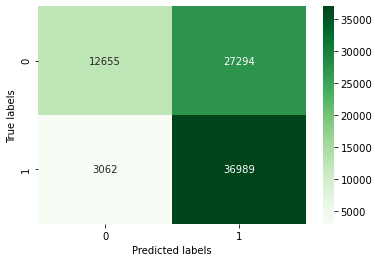

In [43]:
sb.heatmap(cnf, annot=True, cmap='Greens', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

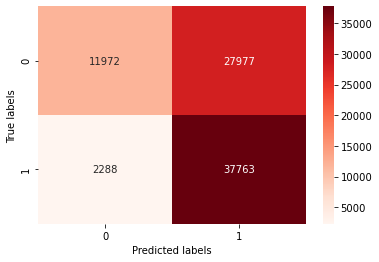

In [63]:
sb.heatmap(forest_cnf, annot=True, cmap='Reds', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

HYPERTUNING:

In [64]:
# For, logistic regression the main hyperparameter to tune is the **regularization strength** (also $\lambda$ or C).

print("The model selected a regularization strength 'C' of: ")
print(model_cv.C_)

The model selected a regularization strength 'C' of: 
[0.1]


Doing our own testing:

In [156]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Define the pipeline to scale the data and fit a logistic regression model
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression())
])

# Define the parameter grid to search over
param_grid = {
#      L1 or L2 regularization:
#     C-values to search over:
    'logreg__C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
#     searching which solver will be best:
    'logreg__solver': ['liblinear', 'saga', 'newton-cg', 'lbfgs'], 
    
    'logreg__class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2}, {0: 1, 1: 3}]
}

# Create a GridSearchCV object and fit it to the data
grid_search = GridSearchCV(pipe, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding score
best_params = grid_search.best_params_
best_score = grid_search.best_score_



In [157]:
print("Best hyperparameters: ", best_params)
print("Best score: ", best_score)

Best hyperparameters:  {'logreg__C': 0.0001, 'logreg__class_weight': {0: 1, 1: 2}, 'logreg__solver': 'liblinear'}
Best score:  0.6226375


Evaluation:

In [158]:
model = LogisticRegression(C=best_params["logreg__C"],solver=best_params["logreg__solver"], class_weight=best_params["logreg__class_weight"])


In [159]:
model.fit(X_train, y_train)

LogisticRegression(C=0.0001, class_weight={0: 1, 1: 2}, solver='liblinear')

In [160]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)
print(y_pred)

[1 1 1 ... 1 1 1]


In [161]:
scores = cross_val_score(model, X_train, y_train, cv=5)
print(scores)
print(scores.mean())

[0.60723437 0.60971875 0.60835938 0.60846875 0.61075   ]
0.60890625


In [162]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

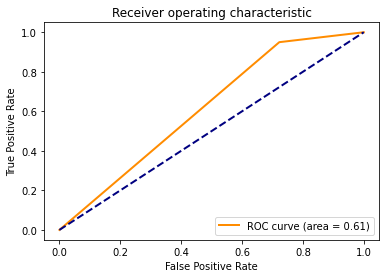

In [163]:
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [164]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.6141

In [165]:
# compute confusion matrix
confusion = confusion_matrix(y_test, y_pred)

In [166]:
# compute precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
print("Precision: {0} \nRecall: {1} \nF1 Score: {2}".format(precision, recall, f1_score, _))

Precision: 0.7073619526367414 
Recall: 0.6141 
F1 Score: 0.5648788063566026


In [167]:
tuned_report = metrics.classification_report(y_test, y_pred)
print(tuned_report)

              precision    recall  f1-score   support

           0       0.85      0.28      0.42     39949
           1       0.57      0.95      0.71     40051

    accuracy                           0.61     80000
   macro avg       0.71      0.61      0.56     80000
weighted avg       0.71      0.61      0.56     80000



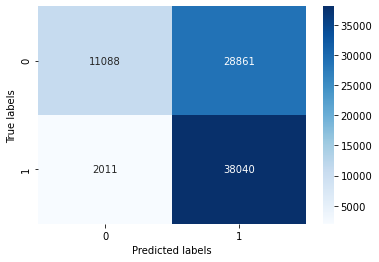

In [168]:
# create a heatmap of the confusion matrix
sb.heatmap(confusion, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()